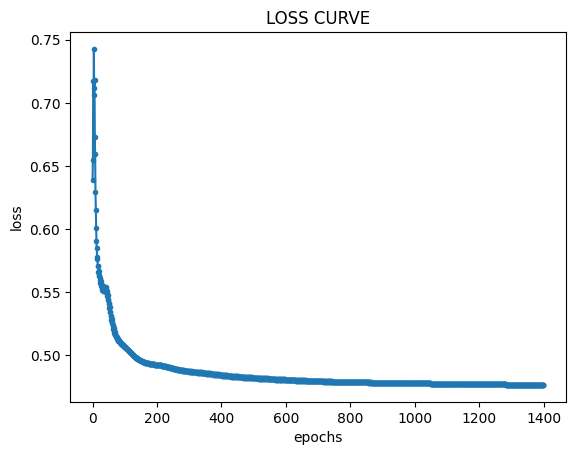

accuracy:  0.6625


In [155]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

class ANN():
    def __init__(self, hidden_node = 15, alpha = 0.006, epochs = 1400):
        '''
        只需传入参数hidden_node, alpha和epochs 其余参数从预处理操作中得出
        '''
        self.input_node  = 0                    #输入层节点数
        self.hidden_node = hidden_node          #隐藏层节点数
        self.output_node = 3                    #输出层节点数
        self.alpha   = alpha                    #学习率
        self.epochs  = epochs                   #训练轮数 
        self.x_train = 0                        #训练样本x
        self.x_test  = 0                        #测试样本x
        self.y_train = 0                        #训练样本y
        self.y_test  = 0                        #测试样本y
        self.v = 0                              #输入层和隐藏层权重
        self.w = 0                              #隐藏层和输出层权重
        self.b1 = 0                             #隐藏层偏置
        self.b2 = 0                             #输出层偏置
        self.LOSS = []                          #训练损失值
        self.train_cnt = 0                      #训练样本数
        self.test_cnt  = 0                      #测试样本数


    # 从xlsx中读取数据，并分割数据集和初始化参数
    def pre_process(self, data_name):
        # 把Excel文件中的数据读入pandas 
        df = pd.read_excel(data_name, sheet_name='Sheet1')
        # 输入层节点数直接从数据处理中得出
        self.input_node = len(df.columns) - 1
        # 将x组合起来，shape为n x m， 其中n是输入层数，m为样本总数
        x = np.array(df[df.columns[0]]).T
        for i in range(1, len(df.columns) - 1):
            tmp = np.array(df[df.columns[i]]).T
            x = np.vstack((x,tmp))
        # 将标签转为独热码
        y = np.array(df[df.columns[self.input_node]])
        y_onehot = []
        # 由于数据集的不同，需要分别进行转换
        '''
        其实这里采用的方法不太满足类的适用性，因为我们必须提前知道标签的种类而
        手动去转换独热码。但考虑到这两个数据的标签都只有三类，所以直接用这种比
        较笨的方法，未来面对其他数据集时，可以直接调用OneHotEncoder()
        '''
        if data_name == 'iris_data.xlsx':
            for i in range(len(y)):
                if y[i] == 'Iris-setosa':
                    y_onehot.append([1,0,0])
                elif y[i] == 'Iris-versicolor':
                    y_onehot.append([0,1,0])
                else:
                    y_onehot.append([0,0,1])
        else:
            for i in range(len(y)):
                if y[i] == 'Bad':
                    y_onehot.append([1,0,0])
                elif y[i] == 'Normal':
                    y_onehot.append([0,1,0])
                else:
                    y_onehot.append([0,0,1])
        # 150 X 3 for iris
        y_onehot = np.array(y_onehot)
        # 调用train_test_split对数据集分割，分割后对于鸢尾花数据集，x_test.shape = (45, 4), y_test.shape = (45, 3)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x.T, y_onehot, 
                                                                                test_size = 0.1,
                                                                                stratify = y_onehot)
        self.train_cnt = len(self.x_train)
        self.test_cnt  = len(self.x_test)
        np.random.seed(8)
        # 随机生成权重矩阵和偏置,正太分布
        self.v = np.random.uniform(-1, 1, (self.hidden_node , self.input_node))
        self.w = np.random.uniform(-1, 1, (self.output_node , self.hidden_node))
        self.b1 = np.random.uniform(0, 0, (self.hidden_node , 1))
        self.b2 = np.random.uniform(0, 0, (self.output_node , 1))

    def sigmoid(Self, x):
        return 1.0 / (1 + np.exp(-x))

    # sigmoid导数
    def sigmoid_g(self, x):
        tmp = self.sigmoid(x)
        return tmp * (1 - tmp)

    # 前向计算
    def forwarding(self, x):
        # 隐藏层激活前
        hidden_input = np.dot(self.v, x.T) - self.b1
        # 隐藏层激活后
        hidden_output = self.sigmoid(hidden_input)
        # 输出层激活前
        output_input = np.dot(self.w, hidden_output) - self.b2
        # 输出层激活后
        output_output = self.sigmoid(output_input)
       
        return hidden_output, output_output

    # loss计算
    def cal_loss(self, out, y):
        delta = out - y.T
        # 均方差
        loss = sum(np.diagonal(delta.dot(delta.T))) / self.train_cnt
        self.LOSS.append(loss)

    # 梯度下降法
    def gradient(self):
        ho, oo = self.forwarding(self.x_train)
        self.cal_loss(oo, self.y_train)
        loss = self.y_train.T - oo

        # 对W的梯度
        delta1 = loss * self.sigmoid_g(oo)
        delta_W = np.dot(delta1, ho.T)
        delta_b2 = np.sum(delta1, axis = 1).reshape(self.output_node,1)

        # 对V的梯度
        delta2 = np.dot(self.w.T, delta1) * self.sigmoid_g(ho)
        delta_V = np.dot(delta2, self.x_train)
        delta_b1 = np.sum(delta2, axis = 1).reshape(self.hidden_node,1)

        # 梯度下降过程
        self.w += delta_W * self.alpha
        self.v += delta_V * self.alpha
        self.b2 -= delta_b2 * self.alpha
        self.b1 -= delta_b1 * self.alpha
        
    # 训练过程
    def train(self):
        for i in range(self.epochs):
            self.gradient()

    # LOSS图绘制
    def show(self):
        epoch = range(len(self.LOSS))
        plt.plot(epoch, self.LOSS, '.-',label="Train_Loss")
        plt.title('LOSS CURVE')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

    # 预测
    def predict(self, x, y):
        ho, oo = self.forwarding(x)
        right_num = 0
        pre = np.array(oo).T
        # print(pre)
        for i in range(len(pre)):
            flg = np.argmax(pre[i])
            tmp = [0]*3
            tmp[flg] = 1
            # print("p: ",tmp)
            # print("t: ",y[i])
            if(tmp == list(y[i])):
                right_num += 1
        print("accuracy: ", right_num * 1.0 / len(y))
        # print("right num: ", right_num)
        # print("total:     ",len(y))

    def verify(self):
        x1, x2, y1, y2 = train_test_split(self.x_train, self.y_train, 
                                         test_size = 0.1)
        self.predict(x2, y2)

if __name__ == '__main__':
    model = ANN()
    model.pre_process('winequality_data_.xlsx')
    model.train()
    model.show()
    # model.verify()
    model.predict(model.x_test, model.y_test)